In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import matplotlib.pyplot as plt
from src.Simulator.SSA import SSASimulator
import numpy as np
from src.Estimation.PropNN import FeedForwardPropensityModel
from src.Estimation.PropNN import getTrainDatasetFromSimulations
from src.Models.utils import getReactionsForObservations
from src.Estimation.utils import createPropensityPlot
from src.Estimation.MLE import MLEstimator

# NN for Birth Death Model
First, we build the dynamic model to create the training data

In [8]:
from src.Models.models import BirthDeath
model_bd = BirthDeath()
simulator_bd = SSASimulator(model_bd)

parameters = model_bd.getDefaultParameter()
y, t = simulator_bd.run_ssa(np.array([5]), 1000, parameters)
num_states = y.shape[1]

We set up the NN model

In [9]:
reaction_indices, unique_reaction_mapping = getReactionsForObservations(y, model_bd.getStoichiometry())
num_unique_stoch = len(np.unique(unique_reaction_mapping))

custom_model = FeedForwardPropensityModel(num_inputs = num_states, num_outputs=num_unique_stoch, num_layers=2, num_neurons=8)
train_dataset = getTrainDatasetFromSimulations(y, t, reaction_indices)

We train the model on the training data

In [10]:
custom_model.fit(train_dataset, epochs=100)

Epoch 1/100
Instructions for updating:
Use fn_output_signature instead
8/8 [==============================] - 2s 59ms/step - loss: 277.8756
Epoch 2/100
8/8 [==============================] - 0s 60ms/step - loss: 266.8210
Epoch 3/100
8/8 [==============================] - 1s 68ms/step - loss: 258.7088
Epoch 4/100
8/8 [==============================] - 0s 57ms/step - loss: 253.2942
Epoch 5/100
8/8 [==============================] - 0s 54ms/step - loss: 250.1608
Epoch 6/100
8/8 [==============================] - 0s 58ms/step - loss: 248.6830
Epoch 7/100
8/8 [==============================] - 1s 54ms/step - loss: 248.1600
Epoch 8/100
8/8 [==============================] - 0s 59ms/step - loss: 248.0152
Epoch 9/100
8/8 [==============================] - 0s 56ms/step - loss: 247.9326
Epoch 10/100
8/8 [==============================] - 0s 57ms/step - loss: 247.8155
Epoch 11/100
8/8 [==============================] - 0s 60ms/step - loss: 247.6700
Epoch 12/100
8/8 [==============================

We plot the estimation results

60/60 [==============================] - 0s 2ms/step


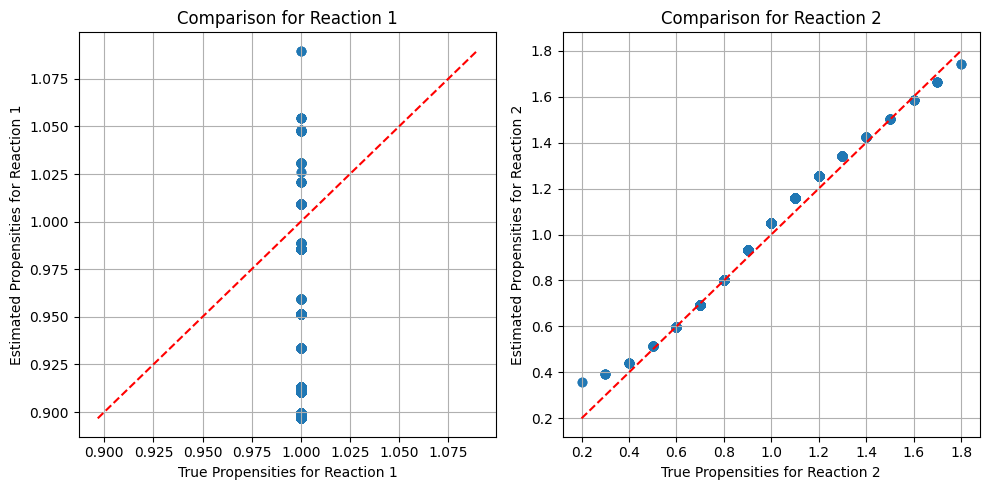

In [17]:
nn_predictions = custom_model.predict(y)

true_props = np.array([model_bd.getPropensities(obs, time) for obs, time in zip(y, t)])
true_props_unique = np.zeros(shape=(true_props.shape[0], num_unique_stoch))
for rct, rct_map in enumerate(unique_reaction_mapping):
    true_props_unique[:, rct_map] += true_props[:, rct]

fig = createPropensityPlot(nn_predictions, true_props_unique)
plt.savefig("bd_comparison.svg")

Lets compare it with the MLE 

/tmp/ipykernel_18643/1584653936.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


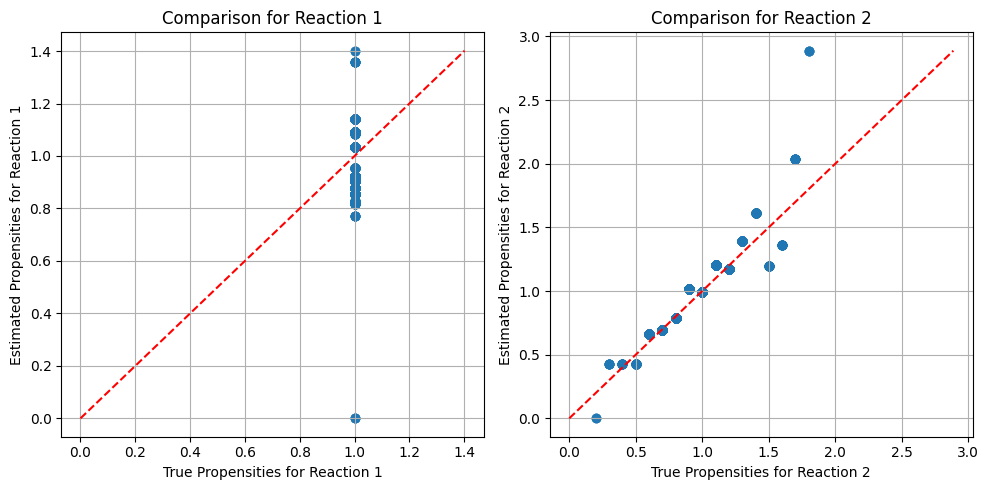

In [18]:
estimator = MLEstimator(model_bd, y, t)
mle_matrix = estimator.computeMLETransitionMatrix()
fig = estimator.plotMLEstimates(mle_matrix)
fig.show()
plt.savefig("bd_comparison_MLE.svg")

# NN for Lotka-Voltera Model

In [29]:
from src.Models.models import ThreeSpeciesModel
model_lv = ThreeSpeciesModel()
simulator_lv = SSASimulator(model_lv)

parameters = model_lv.getDefaultParameter()
y, t = simulator_lv.run_ssa(np.array([80000, 10, 10]), 10000, parameters)
num_states = y.shape[1]

In [30]:
reaction_indices, unique_reaction_mapping = getReactionsForObservations(y, model_lv.getStoichiometry())
num_unique_stoch = len(np.unique(unique_reaction_mapping))

custom_model = FeedForwardPropensityModel(num_inputs=num_states, num_outputs=num_unique_stoch, num_layers=6, num_neurons=256)
train_dataset = getTrainDatasetFromSimulations(y, t, reaction_indices, batch_size=512)

In [31]:
custom_model.fit(train_dataset, epochs=500)

Epoch 1/500
671/671 [==============================] - 90s 131ms/step - loss: 8223.5059
Epoch 2/500
671/671 [==============================] - 101s 151ms/step - loss: -71.5742
Epoch 3/500
671/671 [==============================] - 172s 256ms/step - loss: -290.0982
Epoch 4/500
671/671 [==============================] - 178s 265ms/step - loss: -59.3361
Epoch 5/500
671/671 [==============================] - 180s 269ms/step - loss: -206.6986
Epoch 6/500
671/671 [==============================] - 225s 336ms/step - loss: -290.2509
Epoch 7/500
671/671 [==============================] - 236s 352ms/step - loss: -290.3492
Epoch 8/500
671/671 [==============================] - 309s 460ms/step - loss: -290.8749
Epoch 9/500
671/671 [==============================] - 301s 448ms/step - loss: -292.3014
Epoch 10/500
671/671 [==============================] - 159s 237ms/step - loss: -294.5836
Epoch 11/500
671/671 [==============================] - 153s 227ms/step - loss: -296.2689
Epoch 12/500
671/671 [

KeyboardInterrupt: 

1019/1019 [==============================] - 2s 2ms/step
Mean Squared Error between NN predictions and expected propensities: 4.979222657662776


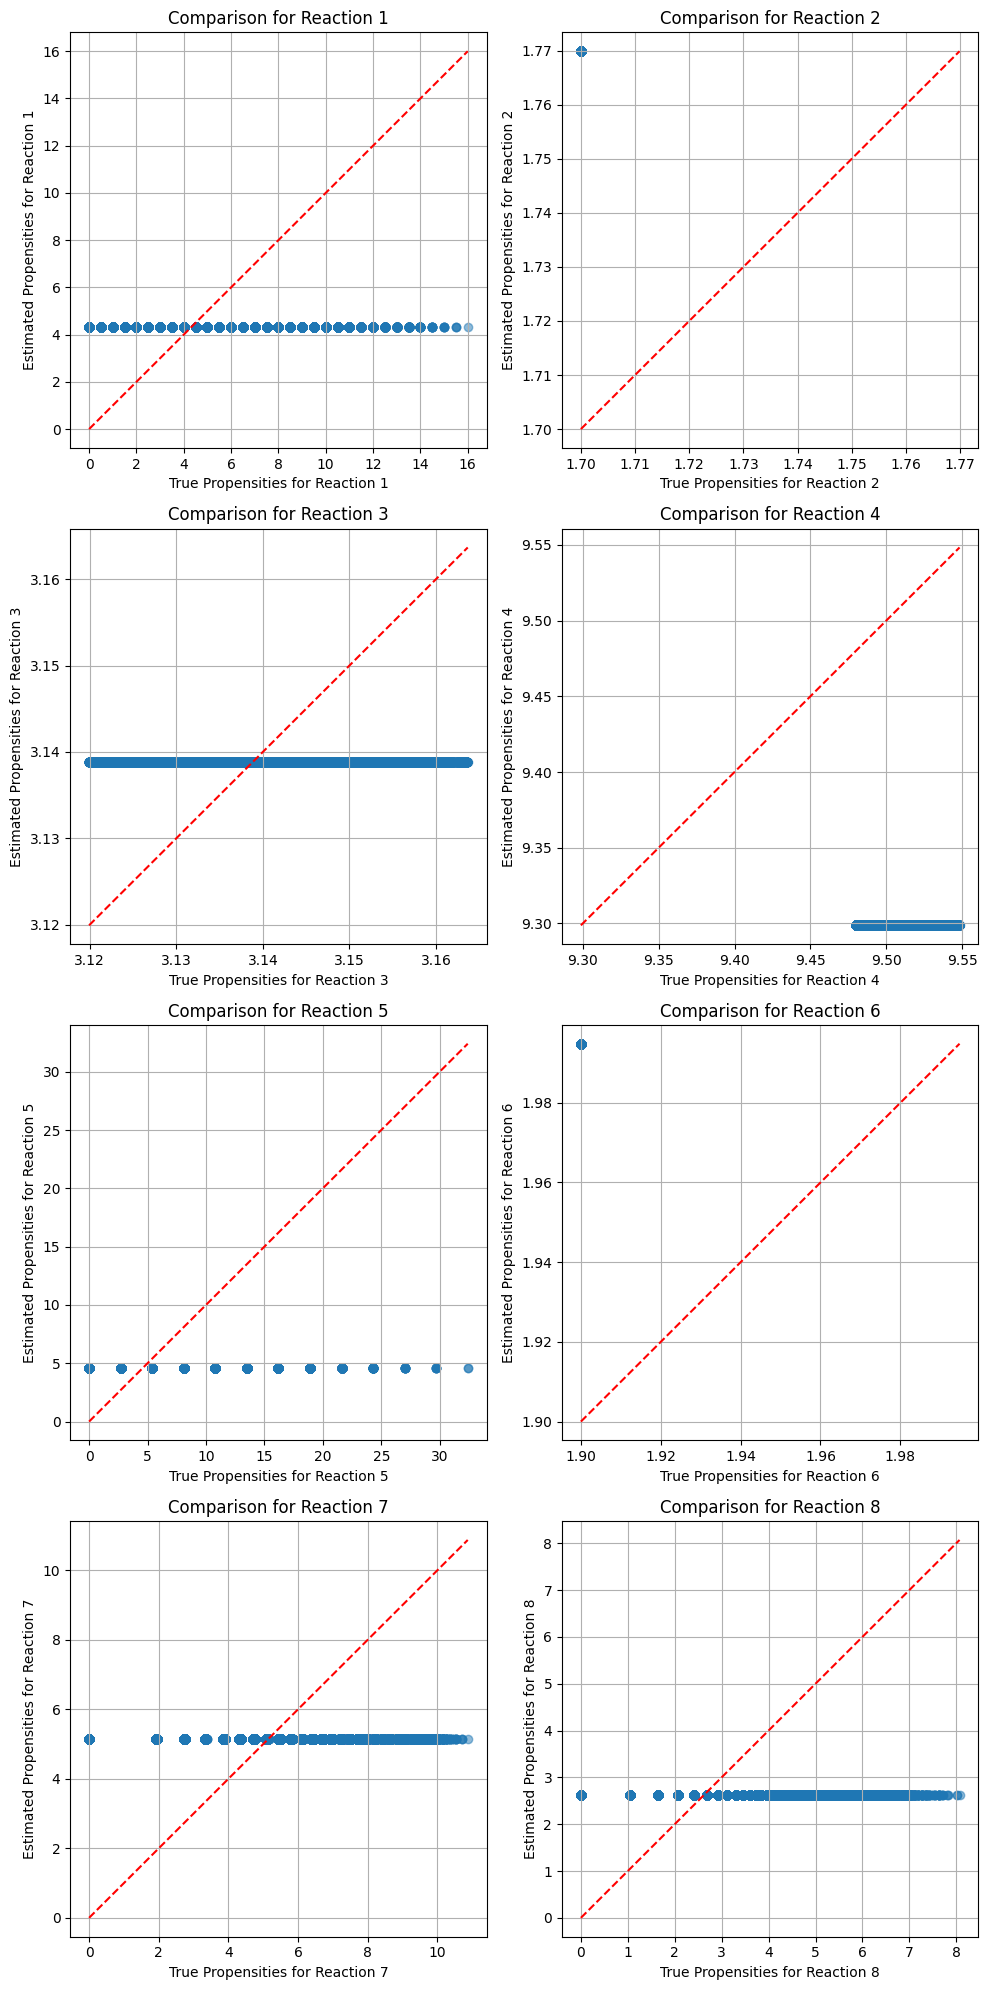

In [48]:
nn_predictions = custom_model.predict(y)

true_props = np.array([model_lv.getPropensities(obs, time) for obs, time in zip(y, t)])
true_props_unique = np.zeros(shape=(true_props.shape[0], num_unique_stoch))
for rct, rct_map in enumerate(unique_reaction_mapping):
    true_props_unique[:, rct_map] += true_props[:, rct]
fig = createPropensityPlot(nn_predictions, true_props_unique)

# NN for Chemical Reaction Network Model


In [20]:
from src.Models.models import ChemicalReactionNetwork
model_crn = ChemicalReactionNetwork()
simulator_crn = SSASimulator(model_crn)

parameters = model_crn.getDefaultParameter()
y, t = simulator_crn.run_ssa(np.array([1, 3]), 10000, parameters)
num_states = y.shape[1]

In [21]:
reaction_indices, unique_reaction_mapping = getReactionsForObservations(y, model_crn.getStoichiometry())
num_unique_stoch = len(np.unique(unique_reaction_mapping))

custom_model = FeedForwardPropensityModel(num_inputs=num_states, num_outputs=num_unique_stoch, num_layers=4)
train_dataset = getTrainDatasetFromSimulations(y, t, reaction_indices, batch_size=512)

In [22]:
custom_model.fit(train_dataset, epochs=200)

Epoch 1/200
5/5 [==============================] - 3s 100ms/step - loss: 3454.0417
Epoch 2/200
5/5 [==============================] - 0s 97ms/step - loss: 2349.3857
Epoch 3/200
5/5 [==============================] - 0s 94ms/step - loss: 2363.5127
Epoch 4/200
5/5 [==============================] - 0s 94ms/step - loss: 2217.9226
Epoch 5/200
5/5 [==============================] - 1s 109ms/step - loss: 2031.4518
Epoch 6/200
5/5 [==============================] - 1s 99ms/step - loss: 1954.3684
Epoch 7/200
5/5 [==============================] - 1s 102ms/step - loss: 1915.4304
Epoch 8/200
5/5 [==============================] - 0s 90ms/step - loss: 1856.0748
Epoch 9/200
5/5 [==============================] - 0s 97ms/step - loss: 1832.7510
Epoch 10/200
5/5 [==============================] - 1s 99ms/step - loss: 1805.2074
Epoch 11/200
5/5 [==============================] - 0s 91ms/step - loss: 1792.4410
Epoch 12/200
5/5 [==============================] - 0s 97ms/step - loss: 1780.5358
Epoch 13/2

79/79 [==============================] - 0s 2ms/step


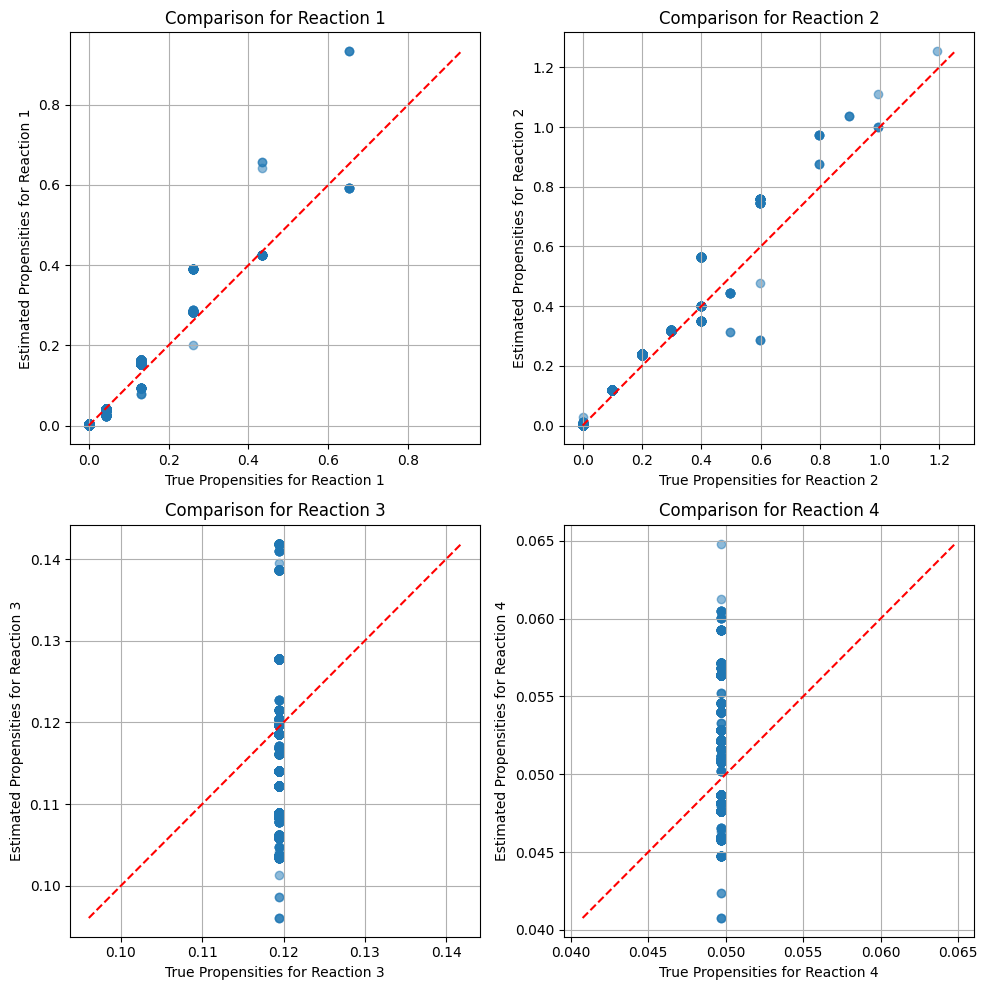

In [23]:
nn_predictions = custom_model.predict(y)

true_props = np.array([model_crn.getPropensities(obs, time) for obs, time in zip(y, t)])
true_props_unique = np.zeros(shape=(true_props.shape[0], num_unique_stoch))
for rct, rct_map in enumerate(unique_reaction_mapping):
    true_props_unique[:, rct_map] += true_props[:, rct]

fig = createPropensityPlot(nn_predictions, true_props_unique)

Compare with MLE

/tmp/ipykernel_18643/13457184.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


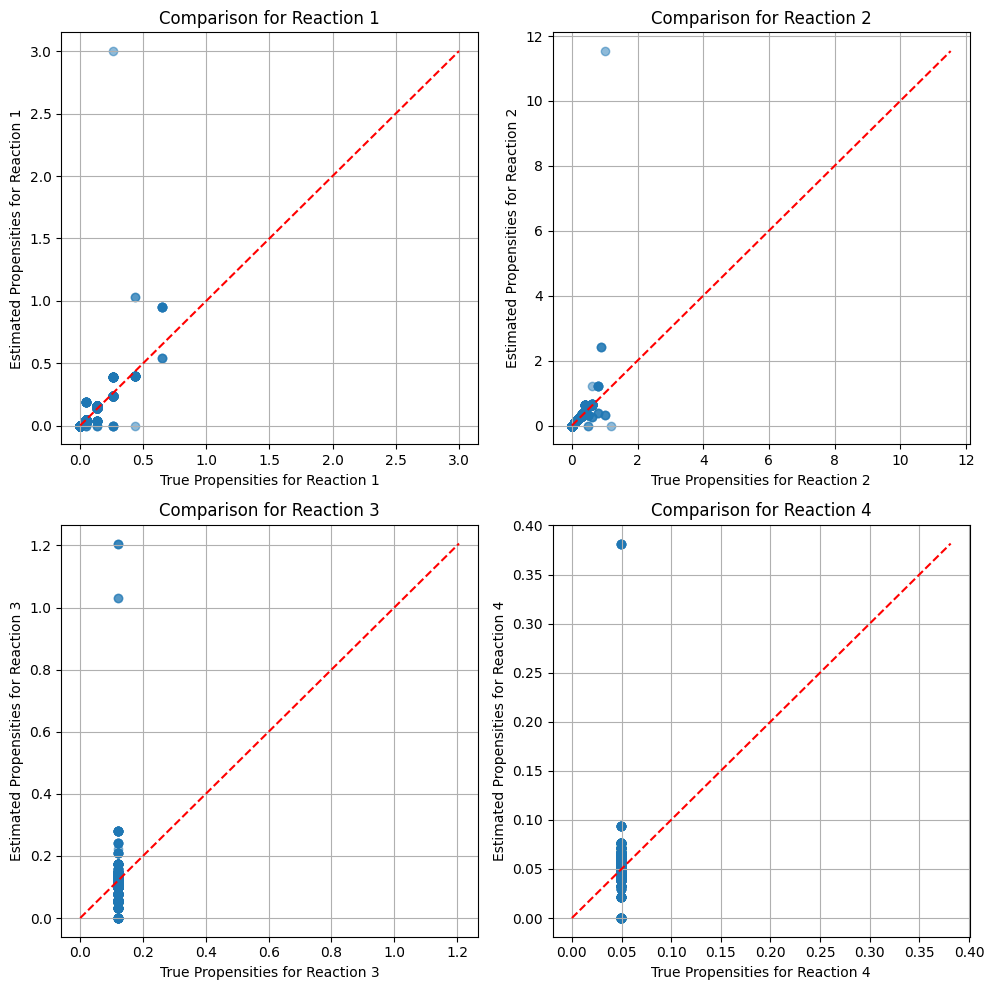

In [24]:
estimator = MLEstimator(model_crn, y, t)
mle_matrix = estimator.computeMLETransitionMatrix()
fig = estimator.plotMLEstimates(mle_matrix)
fig.show()